In [ ]:
import time
import datetime

# Numerical
import numpy as np
import pandas as pd

# Tools
import itertools
from collections import Counter

# NLP
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from pywsd.utils import lemmatize_sentence

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Deep Learing Preprocessing - Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential

# Deep Learning Model - Keras - CNN
from keras.layers import Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D, \
    GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D 
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D

# Deep Learning Model - Keras - RNN
from keras.layers import Embedding, LSTM, Bidirectional

# Deep Learning Model - Keras - General
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply



# Deep Learning Parameters - Keras
from keras.optimizers import RMSprop, Adam

# Deep Learning Callbacs - Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SMSSpamCollection to SMSSpamCollection


In [ ]:
data = pd.read_csv("SMSSpamCollection", sep ='\t',names=["label", "message"])

In [ ]:
minority_len=len(data[data["label"]=="spam"])
majority_len=len(data[data["label"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["label"]=="spam"].index
majority_indices=data[data["label"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=data.loc[undersampled_indices]

#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

#drop the older index
df=df.drop(
    columns=["index"],
)

In [ ]:
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Customer place, i wil cal u sir."
1,ham,Also track down any lighters you can find
2,spam,I don't know u and u don't know me. Send CHAT ...
3,ham,"Hi Shanil,Rakhesh here.thanks,i have exchanged..."
4,spam,Ur HMV Quiz cash-balance is currently £500 - t...


In [ ]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Customer place, i wil cal u sir.",7
1,ham,Also track down any lighters you can find,8
2,spam,I don't know u and u don't know me. Send CHAT ...,28
3,ham,"Hi Shanil,Rakhesh here.thanks,i have exchanged...",16
4,spam,Ur HMV Quiz cash-balance is currently £500 - t...,19


In [ ]:
max(df['message_len'])

171

In [ ]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([747, 747])

In [ ]:
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Customer place, i wil cal u sir.",7,customer place i wil cal u sir
1,ham,Also track down any lighters you can find,8,also track down any lighters you can find
2,spam,I don't know u and u don't know me. Send CHAT ...,28,i dont know u and u dont know me send chat to ...
3,ham,"Hi Shanil,Rakhesh here.thanks,i have exchanged...",16,hi shanilrakhesh herethanksi have exchanged th...
4,spam,Ur HMV Quiz cash-balance is currently £500 - t...,19,ur hmv quiz cashbalance is currently £ to max...


In [ ]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')


stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,target,message,message_len,message_clean
0,ham,"Customer place, i wil cal u sir.",7,customer place wil cal sir
1,ham,Also track down any lighters you can find,8,also track lighters find
2,spam,I don't know u and u don't know me. Send CHAT ...,28,dont know dont know send chat lets find rcvd...
3,ham,"Hi Shanil,Rakhesh here.thanks,i have exchanged...",16,hi shanilrakhesh herethanksi exchanged uncut d...
4,spam,Ur HMV Quiz cash-balance is currently £500 - t...,19,ur hmv quiz cashbalance currently £ maximize ...


In [ ]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Customer place, i wil cal u sir.",7,custom place wil cal sir
1,ham,Also track down any lighters you can find,8,also track lighter find
2,spam,I don't know u and u don't know me. Send CHAT ...,28,dont know dont know send chat let find rcvd ...
3,ham,"Hi Shanil,Rakhesh here.thanks,i have exchanged...",16,hi shanilrakhesh herethanksi exchang uncut dia...
4,spam,Ur HMV Quiz cash-balance is currently £500 - t...,19,ur hmv quiz cashbal current £ maxim ur cashin...


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Customer place, i wil cal u sir.",7,custom place wil cal sir,0
1,ham,Also track down any lighters you can find,8,also track lighter find,0
2,spam,I don't know u and u don't know me. Send CHAT ...,28,dont know dont know send chat let find rcvd ...,1
3,ham,"Hi Shanil,Rakhesh here.thanks,i have exchanged...",16,hi shanilrakhesh herethanksi exchang uncut dia...,0
4,spam,Ur HMV Quiz cash-balance is currently £500 - t...,19,ur hmv quiz cashbal current £ maxim ur cashin...,1


In [ ]:
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

1494 1494


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

1120 1120
374 374


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [ ]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)


In [ ]:
vect_bigram = CountVectorizer(stop_words='english', ngram_range=(1,2))
vect_bigram.fit(x_train)

CountVectorizer(ngram_range=(1, 2), stop_words='english')

In [ ]:
x_train_bigram = vect_bigram.transform(x_train)
x_test_bigram = vect_bigram.transform(x_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

classifier_LR = LogisticRegression()
classifier_SVM = svm.SVC(kernel='linear')



classifier_LR_bigram = LogisticRegression()
classifier_SVM_bigram = svm.SVC(kernel='linear')

classifier_LR_tfidf = LogisticRegression()
classifier_SVM_tfidf = svm.SVC(kernel='linear')


In [ ]:
classifier_LR.fit(x_train_dtm, y_train)
classifier_SVM.fit(x_train_dtm, y_train)

classifier_LR_bigram.fit(x_train_bigram, y_train)
classifier_SVM_bigram.fit(x_train_bigram, y_train)

classifier_LR_tfidf.fit(x_train_tfidf, y_train)
classifier_SVM_tfidf.fit(x_train_tfidf, y_train)

SVC(kernel='linear')

In [ ]:
pd.DataFrame(x_train_dtm).head

<bound method NDFrame.head of                                                       0
0       (0, 165)\t1\n  (0, 312)\t1\n  (0, 407)\t1\n ...
1           (0, 312)\t1\n  (0, 1209)\t1\n  (0, 1359)\t1
2       (0, 164)\t1\n  (0, 266)\t1\n  (0, 312)\t1\n ...
3       (0, 140)\t1\n  (0, 153)\t1\n  (0, 254)\t1\n ...
4       (0, 80)\t1\n  (0, 91)\t2\n  (0, 203)\t2\n  (...
...                                                 ...
1115    (0, 155)\t1\n  (0, 819)\t1\n  (0, 876)\t1\n ...
1116    (0, 437)\t1\n  (0, 564)\t1\n  (0, 649)\t1\n ...
1117    (0, 16)\t1\n  (0, 212)\t1\n  (0, 489)\t1\n  ...
1118    (0, 256)\t1\n  (0, 414)\t1\n  (0, 597)\t1\n ...
1119    (0, 161)\t1\n  (0, 312)\t3\n  (0, 324)\t1\n ...

[1120 rows x 1 columns]>

In [ ]:
pd.DataFrame(x_train_bigram).head

<bound method NDFrame.head of                                                       0
0       (0, 436)\t1\n  (0, 448)\t1\n  (0, 1149)\t1\n...
1          (0, 3843)\t1\n  (0, 4437)\t1\n  (0, 4447)\t1
2       (0, 434)\t1\n  (0, 435)\t1\n  (0, 726)\t1\n ...
3       (0, 363)\t1\n  (0, 400)\t1\n  (0, 404)\t1\n ...
4       (0, 205)\t1\n  (0, 207)\t1\n  (0, 228)\t2\n ...
...                                                 ...
1115    (0, 408)\t1\n  (0, 411)\t1\n  (0, 2512)\t1\n...
1116    (0, 1318)\t1\n  (0, 1319)\t1\n  (0, 1770)\t1...
1117    (0, 38)\t1\n  (0, 40)\t1\n  (0, 574)\t1\n  (...
1118    (0, 700)\t1\n  (0, 701)\t1\n  (0, 1193)\t1\n...
1119    (0, 428)\t1\n  (0, 430)\t1\n  (0, 885)\t1\n ...

[1120 rows x 1 columns]>

In [ ]:
pd.DataFrame(x_train_tfidf).head

<bound method NDFrame.head of                                                       0
0       (0, 165)\t0.30503290126446936\n  (0, 312)\t0...
1       (0, 312)\t0.3264961877466804\n  (0, 1209)\t0...
2       (0, 164)\t0.30808143495538987\n  (0, 266)\t0...
3       (0, 140)\t0.42808317978708965\n  (0, 153)\t0...
4       (0, 80)\t0.19557681009442415\n  (0, 91)\t0.3...
...                                                 ...
1115    (0, 155)\t0.40157590436574614\n  (0, 819)\t0...
1116    (0, 437)\t0.40673798876404516\n  (0, 564)\t0...
1117    (0, 16)\t0.20851847303250082\n  (0, 212)\t0....
1118    (0, 256)\t0.2561661083647037\n  (0, 414)\t0....
1119    (0, 161)\t0.3450347502676172\n  (0, 312)\t0....

[1120 rows x 1 columns]>

In [ ]:
from sklearn import metrics
predict = [0 for i in range(6)]
predict[0] = classifier_LR.predict(x_test_dtm)
predict[1] = classifier_SVM.predict(x_test_dtm)

predict[2] = classifier_LR_bigram.predict(x_test_bigram)
predict[3] = classifier_SVM_bigram.predict(x_test_bigram)

predict[4] = classifier_LR_tfidf.predict(x_test_tfidf)
predict[5] = classifier_SVM_tfidf.predict(x_test_tfidf)

for i in predict:
  print("accurancy score " + str(metrics.accuracy_score(y_test, i)))
  print("precision score " + str(metrics.precision_score(y_test, i)))
  print("recall " + str(metrics.recall_score(y_test, i)))
  print("f1-score " + str(metrics.f1_score(y_test, i)))
  print("  ")

accurancy score 0.9518716577540107
precision score 0.9707602339181286
recall 0.9273743016759777
f1-score 0.9485714285714285
  
accurancy score 0.9411764705882353
precision score 0.9644970414201184
recall 0.9106145251396648
f1-score 0.9367816091954023
  
accurancy score 0.9411764705882353
precision score 0.9875776397515528
recall 0.888268156424581
f1-score 0.9352941176470588
  
accurancy score 0.946524064171123
precision score 0.9877300613496932
recall 0.8994413407821229
f1-score 0.9415204678362573
  
accurancy score 0.9518716577540107
precision score 0.9763313609467456
recall 0.9217877094972067
f1-score 0.9482758620689654
  
accurancy score 0.9679144385026738
precision score 0.9771428571428571
recall 0.9553072625698324
f1-score 0.9661016949152543
  


Text(50.722222222222214, 0.5, 'True label')

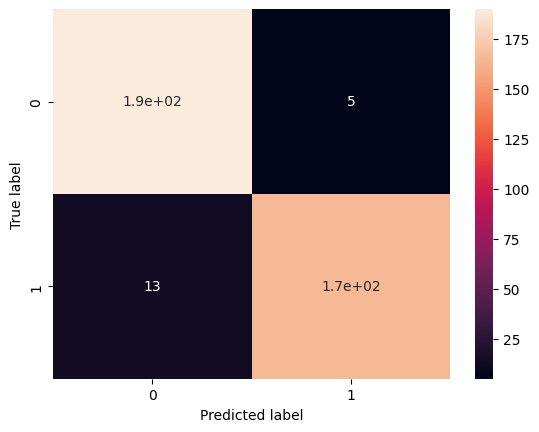

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
cm = confusion_matrix(y_test, predict[0])
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(50.722222222222214, 0.5, 'True label')

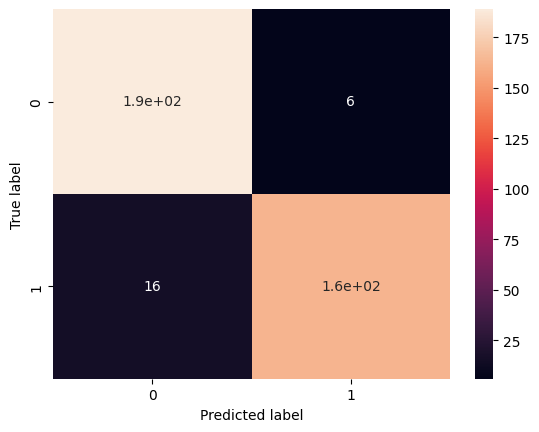

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
cm = confusion_matrix(y_test, predict[1])
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(50.722222222222214, 0.5, 'True label')

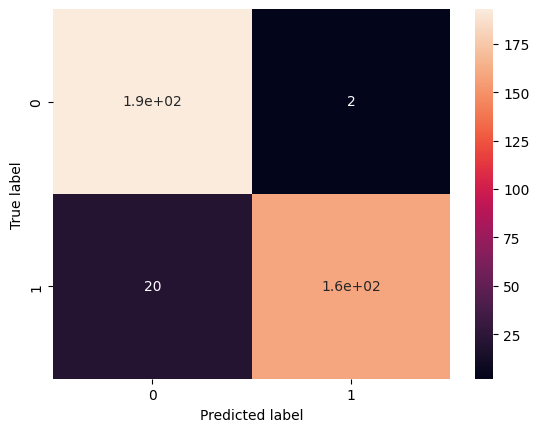

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
cm = confusion_matrix(y_test, predict[2])
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(50.722222222222214, 0.5, 'True label')

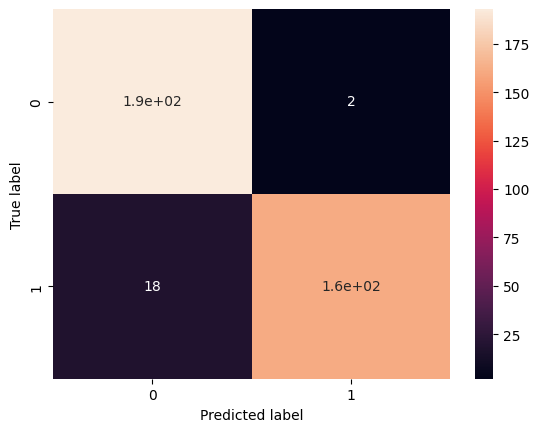

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
cm = confusion_matrix(y_test, predict[3])
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(50.722222222222214, 0.5, 'True label')

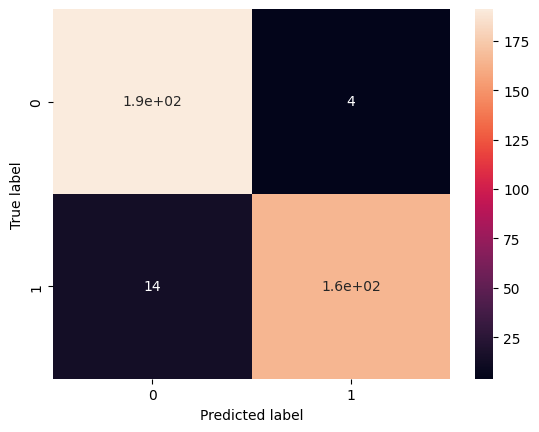

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
cm = confusion_matrix(y_test, predict[4])
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(50.722222222222214, 0.5, 'True label')

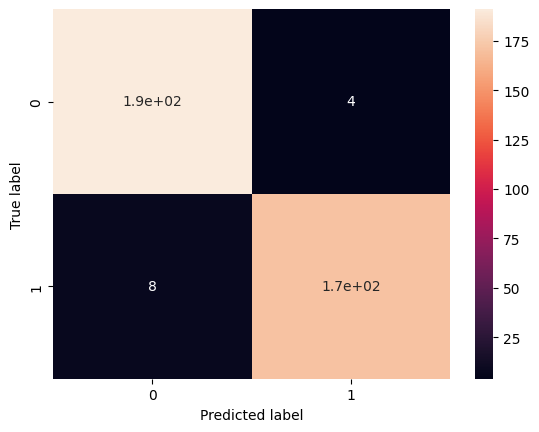

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
cm = confusion_matrix(y_test, predict[5])
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

In [ ]:
texts = df['message_clean']
target = df['target_encoded']

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

3206

In [ ]:
nltk.download('punkt')
import tensorflow as tf
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = tf.keras.utils.pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


array([[  33,  183,  554, ...,    0,    0,    0],
       [ 158, 1472, 1473, ...,    0,    0,    0],
       [  28,   30,   28, ...,    0,    0,    0],
       ...,
       [  72,   67,  544, ...,    0,    0,    0],
       [  88,   12, 1439, ...,    0,    0,    0],
       [   4,  417,  225, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target
)


In [ ]:
def get_rnn_model():
    model = Sequential()

    model.add(Embedding(vocab_length, 100, input_length=length_long_sentence))
    model.add(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.summary()
    
    return model


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=1,
    verbose=1)

callbacks = [reduce_lr, early_stopping]

In [ ]:
reduce_lr_1 = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

In [ ]:
model1 = get_rnn_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 100)           320600    
                                                                 
 lstm_1 (LSTM)               (None, 80, 80)            57920     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 80)               0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_1 (Batc  (None, 80)               320       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 80)               

In [ ]:
model1.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history1 = model1.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_split=0.2,
    verbose = 1,
    callbacks = callbacks
)


Epoch 1/7
28/28 [==============================] - 4s 92ms/step - loss: 0.6465 - accuracy: 0.6205 - val_loss: 0.6804 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 2/7
28/28 [==============================] - 3s 109ms/step - loss: 0.3731 - accuracy: 0.8683 - val_loss: 0.5504 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 3/7
28/28 [==============================] - 2s 80ms/step - loss: 0.1601 - accuracy: 0.9442 - val_loss: 0.4886 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 4/7
28/28 [==============================] - 2s 76ms/step - loss: 0.0839 - accuracy: 0.9821 - val_loss: 0.4490 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 5/7
28/28 [==============================] - 2s 77ms/step - loss: 0.0317 - accuracy: 0.9944 - val_loss: 0.3774 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 6/7
28/28 [==============================] - 2s 76ms/step - loss: 0.0150 - accuracy: 0.9967 - val_loss: 0.2897 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/7
28/28 [==============================] - 3s 106ms/step - loss: 0.0062 -

In [ ]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

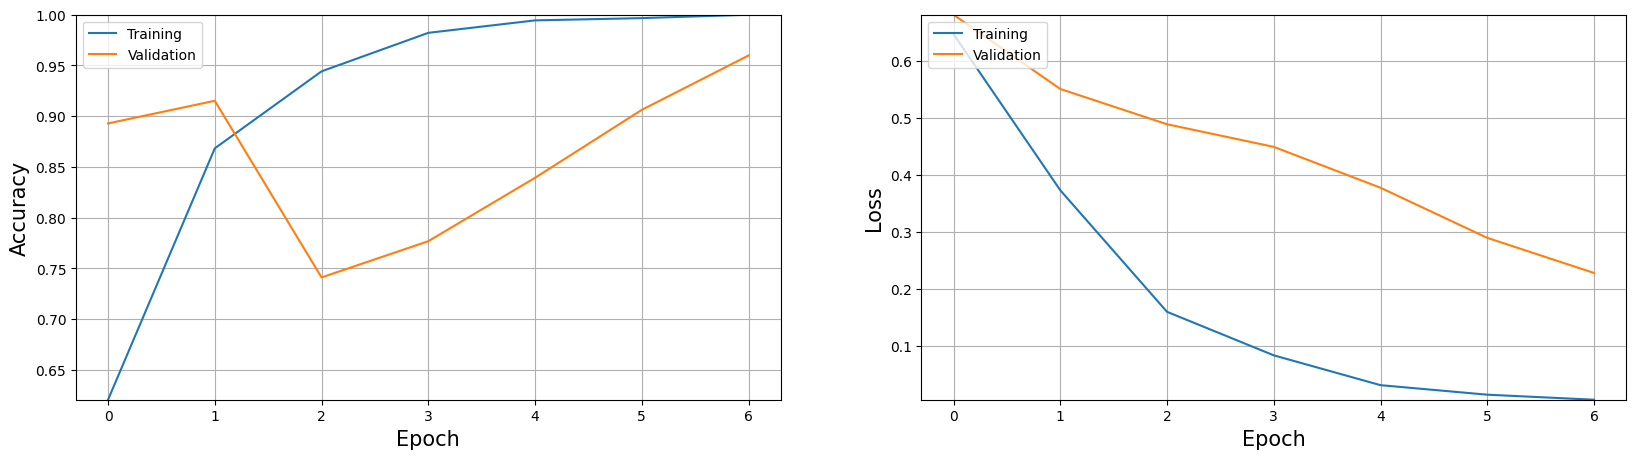

In [ ]:
plot_performance(history=history1)

In [ ]:
def get_cnn_model():   
    model = Sequential()
    
    model.add(Embedding(vocab_length, 50, input_length=length_long_sentence))
    
    model.add(Conv1D(64, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    return model

In [ ]:
model2 = get_cnn_model()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 50)            159650    
                                                                 
 conv1d (Conv1D)             (None, 68, 64)            9664      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [ ]:
learning_rate = 0.001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics="accuracy")

verbose = 1
epochs = 15
batch_size = 32
validation_split = 0.2

print("Trainning Model ...\n")

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_split=validation_split
    )

Trainning Model ...

Epoch 1/15
28/28 [==============================] - 5s 55ms/step - loss: 0.9126 - accuracy: 0.5569 - val_loss: 0.6843 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 2/15
28/28 [==============================] - 1s 24ms/step - loss: 0.7616 - accuracy: 0.6395 - val_loss: 0.6696 - val_accuracy: 0.8304 - lr: 0.0010
Epoch 3/15
28/28 [==============================] - 1s 30ms/step - loss: 0.6464 - accuracy: 0.6998 - val_loss: 0.6484 - val_accuracy: 0.6741 - lr: 0.0010
Epoch 4/15
28/28 [==============================] - 1s 19ms/step - loss: 0.5114 - accuracy: 0.7522 - val_loss: 0.6149 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 5/15
28/28 [==============================] - 0s 12ms/step - loss: 0.3816 - accuracy: 0.8281 - val_loss: 0.5768 - val_accuracy: 0.7902 - lr: 0.0010
Epoch 6/15
28/28 [==============================] - 0s 11ms/step - loss: 0.2837 - accuracy: 0.8873 - val_loss: 0.5325 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 7/15
28/28 [==============================] - 0s 

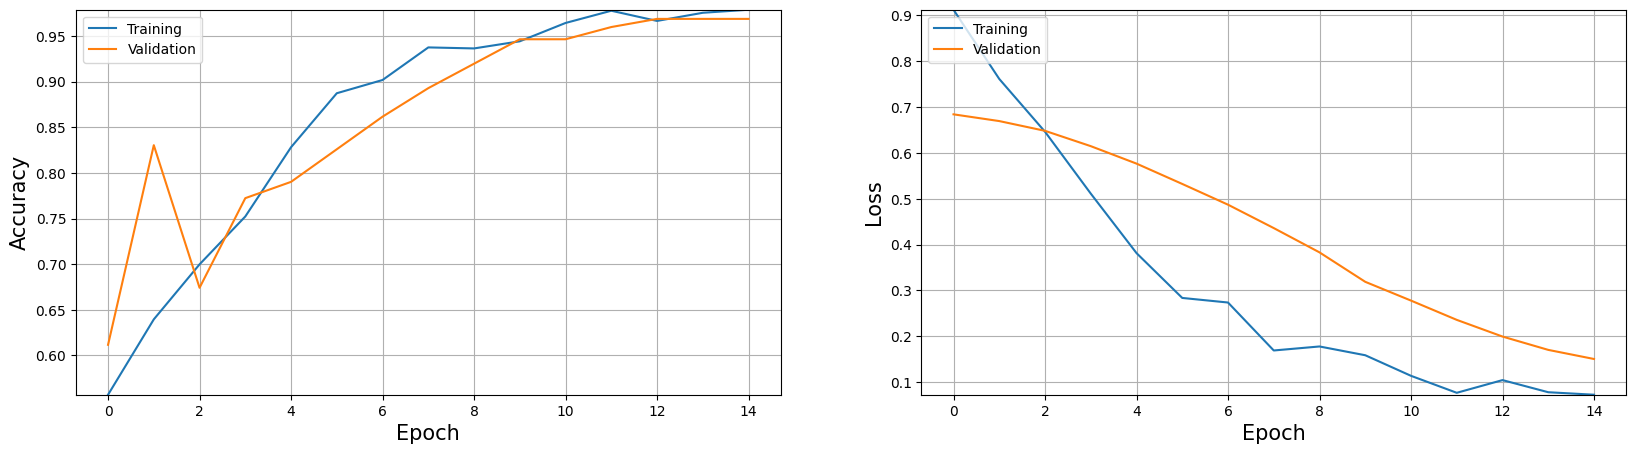

In [ ]:
plot_performance(history=history2)

In [ ]:
accuracy1 = model1.evaluate(X_test, y_test)
accuracy2 = model2.evaluate(X_test, y_test )

12/12 [==============================] - 0s 4ms/step - loss: 0.1837 - accuracy: 0.9519


In [ ]:
print("Model Performance of LSTM (Test Accuracy):")
print('Accuracy: {:0.2f}%\nLoss: {:0.3f}\n'.format(accuracy1[1]*100, accuracy1[0]))

print("\nModel Performance of CNN (Test Accuracy):")
print('Accuracy: {:0.2f}%\nLoss: {:0.3f}\n'.format(accuracy2[1]*100, accuracy2[0]))

Model Performance of LSTM (Test Accuracy):
Accuracy: 92.25%
Loss: 0.248


Model Performance of CNN (Test Accuracy):
Accuracy: 95.19%
Loss: 0.184



In [ ]:
y_preds1 = (model1.predict(X_test) > 0.5).astype("int32")
y_preds2 = (model2.predict(X_test) > 0.5).astype("int32")


12/12 [==============================] - 0s 4ms/step


In [ ]:
from sklearn import metrics
print("accurancy score " + str(metrics.accuracy_score(y_test, y_preds1)))
print("precision score " + str(metrics.precision_score(y_test, y_preds1)))
print("recall " + str(metrics.recall_score(y_test, y_preds1)))
print("f1-score " + str(metrics.f1_score(y_test, y_preds1)))

accurancy score 0.9224598930481284
precision score 0.883177570093458
recall 0.9792746113989638
f1-score 0.9287469287469288


In [ ]:
print("accurancy score " + str(metrics.accuracy_score(y_test, y_preds2)))
print("precision score " + str(metrics.precision_score(y_test, y_preds2)))
print("recall " + str(metrics.recall_score(y_test, y_preds2)))
print("f1-score " + str(metrics.f1_score(y_test, y_preds2)))

accurancy score 0.9518716577540107
precision score 0.9629629629629629
recall 0.9430051813471503
f1-score 0.9528795811518324


Text(50.722222222222214, 0.5, 'True label')

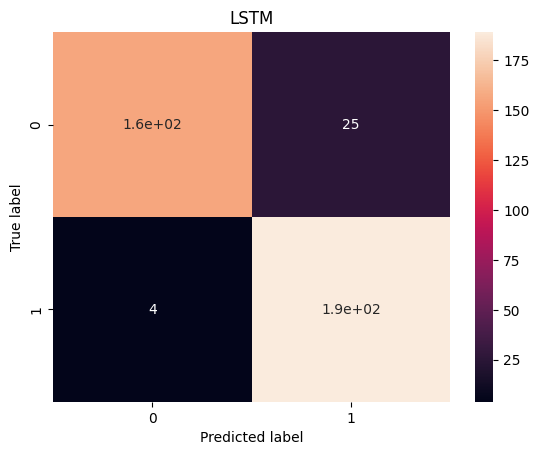

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
plt.title('LSTM')
cm = confusion_matrix(y_test, y_preds1)
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(50.722222222222214, 0.5, 'True label')

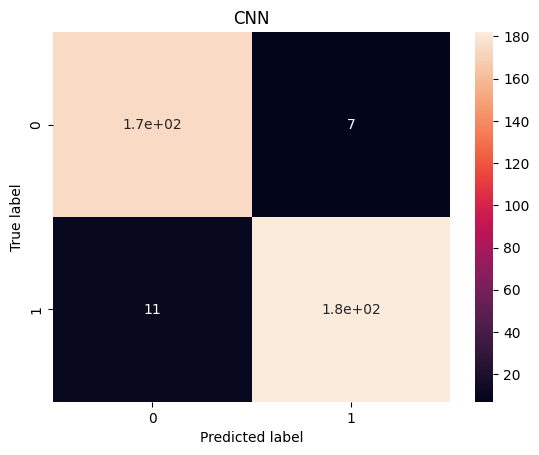

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
plt.title('CNN')
cm = confusion_matrix(y_test, y_preds2)
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

In [ ]:
model1.save('lstm.h5')
model2.save('cnn_2.h5')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow-text
import tensorflow_text as text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.3 MB/s eta 0:00:00


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [ ]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['message'], df['target_encoded'], random_state=42)

In [ ]:
model_BRT_1 = tf.keras.Model(inputs=[text_input], outputs = [l])
model_BRT_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_BRT_1.fit(x_train, y_train, epochs=4, batch_size = 32, validation_split=0.2)

Epoch 1/4
28/28 [==============================] - 395s 14s/step - loss: 0.6535 - accuracy: 0.6183 - val_loss: 0.5801 - val_accuracy: 0.7545
Epoch 2/4
28/28 [==============================] - 377s 14s/step - loss: 0.5380 - accuracy: 0.8125 - val_loss: 0.4897 - val_accuracy: 0.8795
Epoch 3/4
28/28 [==============================] - 383s 14s/step - loss: 0.4630 - accuracy: 0.8549 - val_loss: 0.4382 - val_accuracy: 0.8839
Epoch 4/4
28/28 [==============================] - 384s 14s/step - loss: 0.4122 - accuracy: 0.8795 - val_loss: 0.4031 - val_accuracy: 0.8929


In [ ]:
y_preds3=model_BRT_1.predict(x_test)

12/12 [==============================] - 128s 11s/step


In [ ]:
y_preds3 = ((y_preds3) > 0.5).astype("int32")

In [ ]:
print("accurancy score " + str(metrics.accuracy_score(y_test, y_preds3)))
print("precision score " + str(metrics.precision_score(y_test, y_preds3)))
print("recall " + str(metrics.recall_score(y_test, y_preds3)))
print("f1-score " + str(metrics.f1_score(y_test, y_preds3)))

accurancy score 0.9144385026737968
precision score 0.92
recall 0.8994413407821229
f1-score 0.9096045197740114


Text(50.722222222222214, 0.5, 'True label')

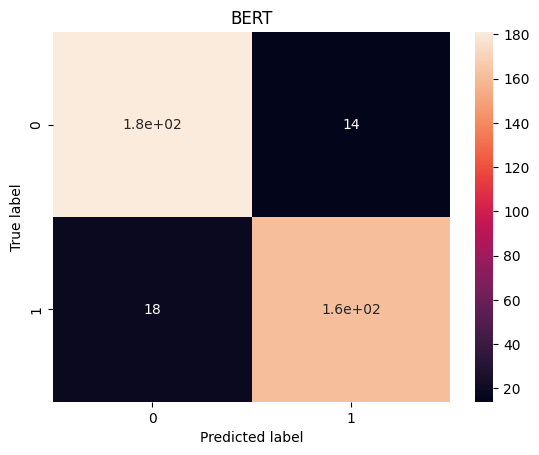

In [ ]:
xlabel = "Predicted label"
ylabel = "True label"
plt.title('BERT')
cm = confusion_matrix(y_test, y_preds3)
sns.heatmap(cm, annot=True)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

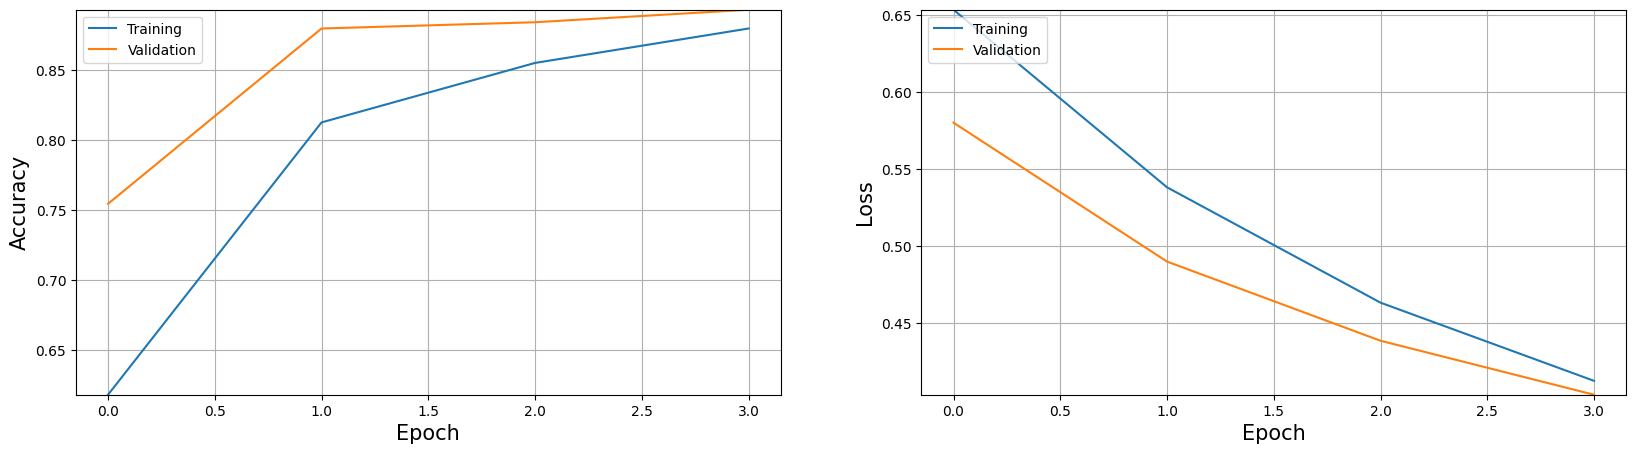

In [ ]:
plot_performance(history)